<h1>Libraries and Utilities</h1>

In [1]:
!pip install tqdm albumentations timm diffusers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 38.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import gc
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn,optim

from torchvision.transforms import v2
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset, Subset

# from diffusers import StableDiffusionPipeline, UNet2DConditionModel

import timm

from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error,mean_squared_error,balanced_accuracy_score, precision_score, recall_score,f1_score, matthews_corrcoef, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)

In [3]:
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])

In [4]:
NUM_ORDINAL_CLASSES = 4
K_FOLDS = 10

<h2>Utils functions</h2>

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, aOriginalImages, aLabels):
        self.original_images = aOriginalImages
        self.labels = aLabels

    def __len__(self):
        return len(self.original_images)
        
    def __getitem__(self, idx):
        imgs = self.original_images[idx]
            
        labels = self.labels[idx]
        
        return imgs, labels

In [ ]:
def imshow(axe,img):
    npimg = img.numpy()
    axe.imshow(np.transpose(npimg, (1, 2, 0)))
    axe.axis('off')

In [ ]:
def create_binary_labels_torch(aOrdinalLabels, aClass):
    num_samples = len(aOrdinalLabels)
    binary_labels = []
    labels_k = torch.zeros(num_samples, dtype=torch.float32)
    labels_k[aOrdinalLabels >= aClass] = 1.0
    binary_labels.append(labels_k.unsqueeze(1))
    return torch.cat(binary_labels, dim=1)

In [ ]:
def aggregate_confusion_matrix(aConfusionMatrix):
    total_cm = 0

    for cm_lst in aConfusionMatrix:
        total_cm += cm_lst

    return total_cm

In [ ]:
class EarlyStopping:
    def __init__(self, aPatience, aDelta=0.01):
        self.patience = aPatience
        self.delta = aDelta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):

        if self.best_score is None:
            self.best_score = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [ ]:
class MulticlassDataset(Dataset):
    def __init__(self, aOriginalImages, aLabels, aTransform=None, aAlbumentations=None):
        self.original_images = aOriginalImages
        self.labels = aLabels
        self.transform = aTransform
        self.albumentations = aAlbumentations

    def __len__(self):
        return len(self.original_images)
        
    def __getitem__(self, idx):
        imgs = self.original_images[idx]
        image = imgs
        if self.transform is not None:
            image = self.transform(imgs)
        if self.albumentations is not None:
            img_transposed = np.transpose(imgs, (1, 2, 0))
            image =  self.albumentations(image=img_transposed.numpy())['image']
            
        labels = self.labels[idx]
        
        return image, labels

In [ ]:
# CNN architecture
class MulticlassNet(nn.Module):
    def __init__(self, aNumOrdinalClasses=4):
        super(OrdinalClassifier, self).__init__()

        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        feature_dim = self.backbone.fc.in_features # self.backbone.fc.in_features (in case of ResNet50)
        self.backbone.fc = nn.Identity()

        for name, child in self.backbone.named_children():
            if not name in ["layer3","layer4","avgpool","fc"]:
                for params in child.parameters():
                    params.requires_grad = False

        self.head = nn.Sequential(
            nn.BatchNorm1d(feature_dim),
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, aNumOrdinalClasses)
        )

    def forward(self, x):
        features = self.backbone(x)
        probs = self.head(features)
        
        return probs

In [ ]:
# ViT architecture
class MulticlassTransformer(nn.Module):
    def __init__(self, aNumOrdinalClasses=4):
        super(OrdinalClassifier, self).__init__()

        self.backbone = timm.create_model("vit_base_patch32_224_in21k", pretrained=True, num_classes=0, global_pool='token')
        feature_dim = self.backbone.num_features

        self.head = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Linear(feature_dim, aNumOrdinalClasses)
        )

    def forward(self, x):
        features = self.backbone(x)
        probs = self.head(features)
        
        return probs

In [ ]:
def get_init_multiclass(aTrainSubset,aTestSubset):
    train_images, train_labels = next(iter(DataLoader(aTrainSubset, batch_size=32, shuffle=True)))
    train_dataset = MulticlassDataset(train_images,aTransform=data_augmentation)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    valid_images, valid_labels = next(iter(DataLoader(aTestSubset, batch_size=32, shuffle=True)))
    valid_dataset = MulticlassDataset(valid_images)
    valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

    # Defining model, Loss function, and Optimizer
    model = MulticlassNet()
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    early_stopping = EarlyStopping(4)

    return train_dataloader,valid_dataloader,model,criterion,optimizer,early_stopping

In [ ]:
class OrdinalDataset(Dataset):
    def __init__(self, aImages, aBinaryLabels, aTransform=None, aAlbumentations=None):
        self.images = aImages
        self.binary_labels = aBinaryLabels
        self.transform = aTransform
        self.albumentations = aAlbumentations

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img = self.images[idx]
        image = img
        if self.transform is not None:
            image = self.transform(img)
        if self.albumentations is not None:
            img_transposed = np.transpose(img, (1, 2, 0))
            image =  self.albumentations(image=img_transposed.numpy())['image']
            
        labels = self.binary_labels[idx]
        
        return image, labels

In [ ]:
# CNN architecture
class OrdinalNet(nn.Module):
    def __init__(self, aNumOrdinalClasses=4):
        super(OrdinalClassifier, self).__init__()

        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        for name, child in self.backbone.named_children():
            if not name in ["layer3","layer4","avgpool","fc"]:
                for params in child.parameters():
                    params.requires_grad = False

        self.head = nn.Sequential(
            nn.BatchNorm1d(feature_dim),
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        probs = self.head(features)
        
        return probs

In [ ]:
# ViT architecture
class OrdinalTransformer(nn.Module):
    def __init__(self, aNumOrdinalClasses=4):
        super(OrdinalClassifier, self).__init__()

        self.backbone = timm.create_model("vit_base_patch32_224_in21k", pretrained=True, num_classes=0, global_pool='token')
        feature_dim = self.backbone.num_features

        self.head = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Linear(feature_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        probs = self.head(features)
        
        return probs

In [ ]:
def get_init(aInstantClass,aTrainSubset,aTestSubset):
    train_images, train_labels = next(iter(DataLoader(aTrainSubset, batch_size=32, shuffle=True)))
    binary_train_labels = create_binary_labels_torch(train_labels,aInstantClass)
    train_dataset = OrdinalDataset(train_images,binary_train_labels,aTransform=data_augmentation)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    valid_images, valid_labels = next(iter(DataLoader(aTestSubset, batch_size=32, shuffle=True)))
    binary_valid_labels = create_binary_labels_torch(valid_labels,aInstantClass)
    valid_dataset = OrdinalDataset(valid_images, binary_valid_labels)
    valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

    # Defining model, Loss function, and Optimizer
    model = OrdinalClassifier()
    model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    
    early_stopping = EarlyStopping(4)

    return train_dataloader,valid_dataloader,model,criterion,optimizer,early_stopping

In [ ]:
def get_predictions(aPredictedBinaryProbs):
    # Enforce monotonicity
    for i in range(NUM_ORDINAL_CLASSES - 2):
        mask = aPredictedBinaryProbs[:, i] < aPredictedBinaryProbs[:, i + 1]
        aPredictedBinaryProbs[mask, i + 1] = aPredictedBinaryProbs[mask, i]

    # Convert binary probs to ordinal class probabilities
    ordinal_probs = torch.zeros((aPredictedBinaryProbs.shape[0], NUM_ORDINAL_CLASSES), dtype=torch.float32)
    ordinal_probs[:, 0] = 1 - aPredictedBinaryProbs[:, 0]
    for k in range(1, NUM_ORDINAL_CLASSES - 1):
        ordinal_probs[:, k] = aPredictedBinaryProbs[:, k - 1] - aPredictedBinaryProbs[:, k]
    ordinal_probs[:, -1] = aPredictedBinaryProbs[:, -1]

    # Clip to [0, 1]
    ordinal_probs = torch.clamp(ordinal_probs, 0, 1)

    # Normalize row-wise
    row_sums = ordinal_probs.sum(dim=1, keepdim=True)
    row_sums[row_sums == 0] = 1
    ordinal_probs /= row_sums

    # Argmax for predicted class
    return torch.argmax(ordinal_probs, dim=1)

In [ ]:
class OrdinalFineGrainedDataset(Dataset):
    def __init__(self, aImages, aBinaryLabels, aOrdinalClasses, aTransform=None, aAlbumentations=None):
        self.images = aImages
        self.binary_labels = aBinaryLabels
        self.ordinal_classes = aOrdinalClasses
        self.transform = aTransform
        self.albumentations = aAlbumentations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        image = img
        if self.transform is not None:
            image = self.transform(img)
        if self.albumentations is not None:
            img_transposed = np.transpose(img, (1, 2, 0))
            image =  self.albumentations(image=img_transposed.numpy())['image']
            
        labels = self.binary_labels[idx]
        fine_class = self.ordinal_classes[idx]

        return image, fine_class, labels

In [ ]:
#Weight Ordinal-Fine Loss (WOF-Loss)
class WOFLoss(nn.Module):
    def __init__(self, aAlpha=1.0, aBeta=1.0, aLearnableWeights=False):
        super().__init__()
        self.fine_loss = nn.CrossEntropyLoss()
        self.ordinal_loss = nn.BCELoss()  # Binary cross-entropy for ordinal labels
        self.learnable = aLearnableWeights
        if aLearnableWeights:
            self.log_alpha = nn.Parameter(torch.tensor(0.0))
            self.log_beta = nn.Parameter(torch.tensor(0.0))
        else:
            self.alpha = aAlpha  # Weight for ordinal loss
            self.beta = aBeta  # Weight for fine-grained loss
        

    def forward(self, aFinePred, aFineTarget, aOrdinalPred, aOrdinalTarget):
        loss_fine = self.fine_loss(aFinePred, aFineTarget)  # Fine classification loss
        loss_ordinal = self.ordinal_loss(aOrdinalPred, aOrdinalTarget)  # Ordinal loss

        alpha = torch.exp(self.log_alpha) if self.learnable else self.alpha
        beta = torch.exp(self.log_beta) if self.learnable else self.beta
        return alpha * loss_ordinal + beta * loss_fine 

In [ ]:
#Hierarchical Ordinal-Fine Loss (HOF-Loss)
class HOFLoss(nn.Module):
    def __init__(self, aAlpha=1.0, aBeta=1.0, aGamma=0.1, aLearnableWeights=False):
        super().__init__()
        self.fine_loss = nn.CrossEntropyLoss()
        self.ordinal_loss = nn.BCELoss()  # Binary cross-entropy for ordinal labels
        self.learnable = aLearnableWeights
        self.gamma = aGamma
        if aLearnableWeights:
            self.log_alpha = nn.Parameter(torch.tensor(0.0))
            self.log_beta = nn.Parameter(torch.tensor(0.0))
        else:
            self.alpha = aAlpha  # Weight for ordinal loss
            self.beta = aBeta  # Weight for fine-grained loss
        

    def forward(self, aFinePred, aFineTarget, aOrdinalPred, aOrdinalTarget, aHierarchyMap):
        loss_fine = self.fine_loss(aFinePred, aFineTarget)  # Fine classification loss
        loss_ordinal = self.ordinal_loss(aOrdinalPred, aOrdinalTarget)  # Ordinal loss

        p_fine = F.softmax(aFinePred,dim=1)
        p_ord_from_fine = torch.mm(p_fine, aHierarchyMap)

        loss_consistency = F.kl_div(
            F.log_softmax(p_ord_from_fine, dim=1), 
            aOrdinalPred, 
            reduction="batchmean"
        )

        alpha = torch.exp(self.log_alpha) if self.learnable else self.alpha
        beta = torch.exp(self.log_beta) if self.learnable else self.beta
        return alpha * loss_ordinal + beta * loss_fine + self.gamma * loss_consistency

In [ ]:
# CNN architecture
class OrdinalFineGrainedNet(nn.Module):
    def __init__(self, aNumClasses=4):
        super(OrdinalFineGrainedNet, self).__init__()

        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        for name, child in self.backbone.named_children():
            if not name in ["avgpool","fc","classifier"]:
                for params in child.parameters():
                    params.requires_grad = False

        self.shared_layer = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Linear(feature_dim, 516),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(516, 128),
            nn.ReLU(),
            nn.Dropout()
        )

        self.fine_class_head = nn.Sequential(
            nn.Linear(128, aNumClasses)
        )

        self.ordinal_head = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        shared_output = self.shared_layer(features)
        fine_out = self.fine_class_head(shared_output)
        ordinal_out = self.ordinal_head(shared_output)

        return fine_out, ordinal_out

In [ ]:
# ViT architecture
class OrdinalFineGrainedTransformer(nn.Module):
    def __init__(self, aNumClasses=4):
        super(OrdinalFineGrainedTransformer, self).__init__()

        self.backbone = timm.create_model("vit_base_patch32_224_in21k", pretrained=True, num_classes=0, global_pool='token')
        feature_dim = self.backbone.num_features

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.shared_layer = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 32),
            nn.ReLU()
        )

        self.fine_class_head = nn.Sequential(
            nn.Linear(32, aNumClasses)
        )

        self.ordinal_head = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        shared_output = self.shared_layer(features)
        fine_out = self.fine_class_head(shared_output)
        ordinal_out = self.ordinal_head(shared_output)

        return fine_out, ordinal_out

In [ ]:
def get_init_fine_grained(aInstantClass,aTrainSubset,aTestSubset):
    train_images, train_labels = next(iter(DataLoader(aTrainSubset, batch_size=32, shuffle=True)))
    binary_train_labels = create_binary_labels_torch(train_labels,aInstantClass)
    train_dataset = OrdinalFineGrainedDataset(train_images,binary_train_labels,train_labels,aTransform=data_augmentation)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    valid_images, valid_labels = next(iter(DataLoader(aTestSubset, batch_size=32, shuffle=True)))
    binary_valid_labels = create_binary_labels_torch(valid_labels,aInstantClass)
    valid_dataset = OrdinalFineGrainedDataset(valid_images, binary_valid_labels, valid_labels)
    valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

    # Defining model, Loss function, and Optimizer
    model = OrdinalFineGrainedTransformer()
    model.to(device)
    
    criterion = OrdinalFineGrainedLoss()
    optimizer = optim.Adam(model.parameters())
    
    early_stopping = EarlyStopping(4)

    return train_dataloader,valid_dataloader,model,criterion,optimizer,early_stopping

In [ ]:
def get_predictions_fine_grained(aPredictedBinaryProbs, aPredictedFineGrained):
    # Enforce monotonicity
    for i in range(NUM_ORDINAL_CLASSES - 2):
        mask = aPredictedBinaryProbs[:, i] < aPredictedBinaryProbs[:, i + 1]
        aPredictedBinaryProbs[mask, i + 1] = aPredictedBinaryProbs[mask, i]

    # Convert binary probs to ordinal class probabilities
    ordinal_probs = torch.zeros((aPredictedBinaryProbs.shape[0], NUM_ORDINAL_CLASSES), dtype=torch.float32)
    ordinal_probs[:, 0] = 1 - aPredictedBinaryProbs[:, 0]
    for k in range(1, NUM_ORDINAL_CLASSES - 1):
        ordinal_probs[:, k] = aPredictedBinaryProbs[:, k - 1] - aPredictedBinaryProbs[:, k]
    ordinal_probs[:, -1] = aPredictedBinaryProbs[:, -2]

    # Clip to [0, 1]
    ordinal_probs = torch.clamp(ordinal_probs, 0, 1)

    # Normalize row-wise
    row_sums = ordinal_probs.sum(dim=1, keepdim=True)
    row_sums[row_sums == 0] = 1
    ordinal_probs /= row_sums

    # Argmax for predicted class
    return torch.argmax(ordinal_probs, dim=1), torch.argmax(aPredictedFineGrained, dim=1)

<h1>Data Augmentation</h1>

In [5]:
# Torchvision library
data_augmentation = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.GaussianBlur(kernel_size=5)
])


In [4]:
# Albumentations library
data_augmentation_A = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    A.GaussianBlur(blur_limit=(5, 5)),
    ToTensorV2(),
])


In [ ]:
# GAN - StyleGAN 3

In [ ]:
# Diffusion Model - MediSyn

unet = UNet2DConditionModel.from_pretrained("hiesingerlab/MediSyn", torch_dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", unet=unet, torch_dtype=torch.float16, safety_checker=None)

prompt = "Gastrointestinal endoscopy image showing polyp"

augmented_images = pipe(prompt=[prompt], height=512, width=512, negative_prompt=[""], guidance_scale=7.0)

<h1>Load dataset and Visualize Images</h1>

In [6]:
# Load dataset to Cross Validation
data_dir = '/kaggle/input/ordinal-classification-uc-v2/ordinal_classification_UC/'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [7]:
df_images, df_labels = next(iter(DataLoader(dataset, batch_size=32, shuffle=True)))
dataset_1 = CustomDataset(df_images,df_labels)

In [13]:
df = DataLoader(dataset, batch_size=32, shuffle=True)
count = torch.zeros(NUM_ORDINAL_CLASSES, dtype=torch.long)
for _,labels in df:
    hist = torch.bincount(df_labels, minlength=NUM_ORDINAL_CLASSES)
    count += hist

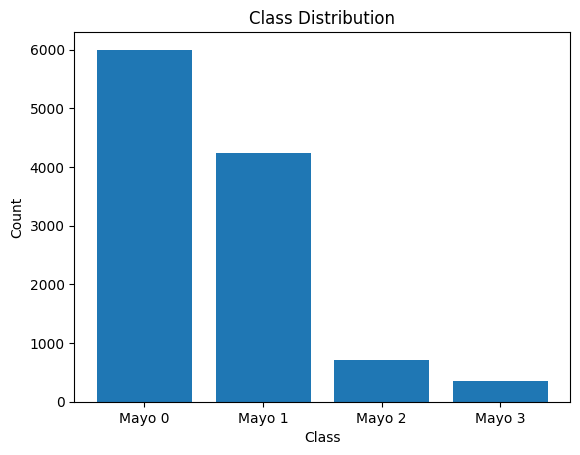

In [18]:
plt.bar(['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3'], count.numpy())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

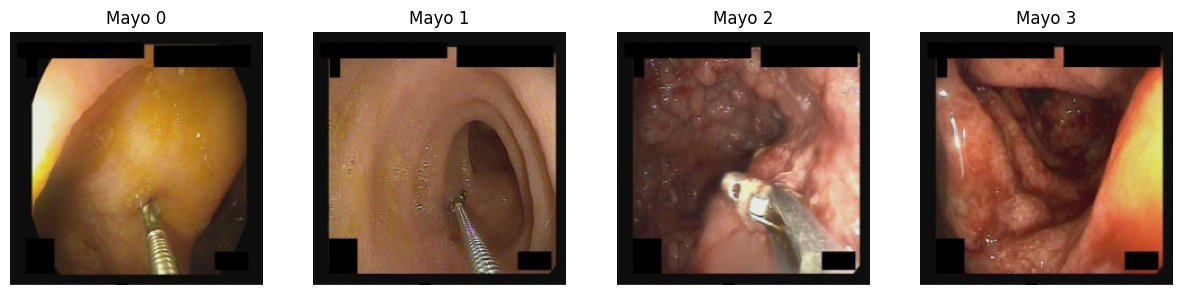

In [50]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15)) 
class_names = dataset.classes
count = 0
previous_label = []
for img, label in zip(df_images, df_labels):
    if count == 0:
        previous_label.append(class_names[label])
        axes[0].set_title(class_names[label])
        imshow(axes[0],img)
        count += 1
    elif class_names[label] not in previous_label:
        previous_label.append(class_names[label])
        axes[count].set_title(class_names[label])
        imshow(axes[count],img)
        count += 1
    if count > 3: break
plt.show()

<h1>Multiclass Classification</h1>

In [ ]:
# Initialize metrics, model storage, and K-Fold Cross Validation
kFold = KFold(n_splits=K_FOLDS, shuffle=True)
overall_acc, overall_pre, overall_recall, overall_f1, overall_mae, overall_mse, overall_mcc, overall_confusion_matrix_list = [], [], [], [], [], [], [], []

# K-Fold Cross Validation
for fold, (train_index, test_index) in enumerate(kFold.split(dataset_1)):
    print(f"\n--- Fold {fold + 1} ---")

    train_subset = Subset(dataset_1, train_index)
    test_subset = Subset(dataset_1, test_index)

    num_epochs = 100
    train_loader, val_loader, model, criterion, optimizer, early_stopping = get_init_multiclass(train_subset, test_subset)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in tqdm(train_loader, desc='Training'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        avg_train_loss = train_loss / len(train_subset)

        # Validation loop
        model.eval()
        val_loss = 0.0
        y_true = torch.tensor([], dtype=torch.float32)
        y_pred = torch.tensor([], dtype=torch.float32)

        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc='Validation'):
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                outputs = model(val_images)
                loss = criterion(outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)

                y_true = torch.cat((y_true, val_labels.cpu()[:, 0]), dim=0)
                y_pred = torch.cat((y_pred, outputs.cpu()[:, 0]), dim=0)

        avg_val_loss = val_loss / len(test_subset)

        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    y_pred_final = torch.argmax(y_pred, dim=1)
    overall_acc.append(balanced_accuracy_score(y_true, y_pred_final))
    overall_pre.append(precision_score(y_true, y_pred_final,average='weighted'))
    overall_recall.append(recall_score(y_true, y_pred_final,average='weighted'))
    overall_f1.append(f1_score(y_true, y_pred_final,average='weighted'))
    overall_mae.append(mean_absolute_error(y_true, y_pred_final))
    overall_mse.append(mean_squared_error(y_true, y_pred_final))
    overall_mcc.append(matthews_corrcoef(y_true, y_pred_final))
    overall_confusion_matrix_list.append(confusion_matrix(y_true, y_pred_final, labels=np.unique(df_labels)))

    del train_subset, test_subset, y_true, y_pred
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU memory cleaned.")

In [ ]:
print("--Final Performance--")
print(f"Accuracy: {np.mean(overall_acc):.4f} +/- {np.std(overall_acc):.2f}")
print(f"Precision: {np.mean(overall_pre):.4f} +/- {np.std(overall_pre):.2f}")
print(f"Recall: {np.mean(overall_recall):.4f} +/- {np.std(overall_recall):.2f}")
print(f"F1-Score: {np.mean(overall_f1):.4f} +/- {np.std(overall_f1):.2f}")

print(f"Mean Absolute Error: {np.mean(overall_mae):.4f} +/- {np.std(overall_mae):.2f}")
print(f"Mean Squared Error: {np.mean(overall_mse):.4f} +/- {np.std(overall_mse):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(overall_mcc):.4f} +/- {np.std(overall_mcc):.2f}")

In [ ]:
cm_classifier = aggregate_confusion_matrix(overall_confusion_matrix_list)

sns.heatmap(
    cm_classifier, 
    annot=True, 
    fmt='g', 
    cmap="YlGnBu", 
    xticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3'],
    yticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
)
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix - Multiclass')

plt.show()

<h1>Ordinal Classification</h1>

In [ ]:
# Initialize metrics, model storage, and K-Fold Cross Validation
kFold = KFold(n_splits=K_FOLDS, shuffle=True)
all_acc, all_pre, all_recall, all_f1, all_mae, all_mse, all_mcc, confusion_matrix_list = [], [], [], [], [], [], [], []
overall_acc, overall_pre, overall_recall, overall_f1, overall_mae, overall_mse, overall_mcc, overall_confusion_matrix_list = [], [], [], [], [], [], [], []

# K-Fold Cross Validation
for fold, (train_index, test_index) in enumerate(kFold.split(dataset_1)):
    print(f"\n--- Fold {fold + 1} ---")

    train_subset = Subset(dataset_1, train_index)
    test_subset = Subset(dataset_1, test_index)

    predicted_binary_probs = torch.zeros((len(test_index), NUM_ORDINAL_CLASSES - 1), dtype=torch.float32)
    _, y_true_all = next(iter(DataLoader(test_subset, batch_size=32, shuffle=True)))

    # Train binary classifiers for each ordinal class
    for binary_class_index in range(NUM_ORDINAL_CLASSES - 1):
        print(f"\nProcessing binary classifier for class {binary_class_index + 1}")

        num_epochs = 100
        train_loader, val_loader, model, criterion, optimizer, early_stopping = get_init(binary_class_index + 1, train_subset, test_subset)
        
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            for images, labels in tqdm(train_loader, desc='Training'):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * images.size(0)

            avg_train_loss = train_loss / len(train_subset)

            # Validation loop
            model.eval()
            val_loss = 0.0
            y_true_fold = torch.tensor([], dtype=torch.float32)
            y_pred_fold = torch.tensor([], dtype=torch.float32)

            with torch.no_grad():
                for val_images, val_labels in tqdm(val_loader, desc='Validation'):
                    val_images, val_labels = val_images.to(device), val_labels.to(device)

                    outputs = model(val_images)
                    loss = criterion(outputs, val_labels)

                    val_loss += loss.item() * val_images.size(0)

                    # Accumulate predictions and true labels
                    y_true_fold = torch.cat((y_true_fold, val_labels.cpu()[:, 0]), dim=0)
                    y_pred_fold = torch.cat((y_pred_fold, outputs.cpu()[:, 0]), dim=0)

            avg_val_loss = val_loss / len(test_subset)
            predicted_binary_probs[:, binary_class_index] = y_pred_fold

            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

        y_pred_bin = (y_pred_fold >= 0.5).int()
        all_acc.append(balanced_accuracy_score(y_true_fold, y_pred_bin))
        all_pre.append(precision_score(y_true_fold, y_pred_bin))
        all_recall.append(recall_score(y_true_fold, y_pred_bin))
        all_f1.append(f1_score(y_true_fold, y_pred_bin))
        all_mae.append(mean_absolute_error(y_true_fold, y_pred_bin))
        all_mse.append(mean_squared_error(y_true_fold, y_pred_bin))
        all_mcc.append(matthews_corrcoef(y_true_fold, y_pred_bin))
        confusion_matrix_list.append(confusion_matrix(y_true_fold, y_pred_bin))

    # Final predictions and metrics
    y_pred_final = get_predictions(predicted_binary_probs)

    overall_acc.append(balanced_accuracy_score(y_true_all, y_pred_final))
    overall_pre.append(precision_score(y_true_all, y_pred_final,average='weighted'))
    overall_recall.append(recall_score(y_true_all, y_pred_final,average='weighted'))
    overall_f1.append(f1_score(y_true_all, y_pred_final,average='weighted'))
    overall_mae.append(mean_absolute_error(y_true_all, y_pred_final))
    overall_mse.append(mean_squared_error(y_true_all, y_pred_final))
    overall_mcc.append(matthews_corrcoef(y_true_all, y_pred_final))
    overall_confusion_matrix_list.append(confusion_matrix(y_true_all, y_pred_final, labels=np.unique(df_labels)))

    del train_subset, test_subset, y_true_fold, y_pred_fold,predicted_binary_probs,y_true_all,y_pred_final
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU memory cleaned.")

In [ ]:
print("--Classifier 1--")
print(f"Accuracy: {np.mean(all_acc[::3]):.4f} +/- {np.std(all_acc[::3]):.2f}")
print(f"Precision: {np.mean(all_pre[::3]):.4f} +/- {np.std(all_pre[::3]):.2f}")
print(f"Recall: {np.mean(all_recall[::3]):.4f} +/- {np.std(all_recall[::3]):.2f}")
print(f"F1-Score: {np.mean(all_f1[::3]):.4f} +/- {np.std(all_f1[::3]):.2f}")

print(f"Mean Absolute Error: {np.mean(all_mae[::3]):.4f} +/- {np.std(all_mae[::3]):.2f}")
print(f"Mean Squared Error: {np.mean(all_mse[::3]):.4f} +/- {np.std(all_mse[::3]):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(all_mcc[::3]):.4f} +/- {np.std(all_mcc[::3]):.2f}")

print("\n--Classifier 2--")
print(f"Accuracy: {np.mean(all_acc[1::3]):.4f} +/- {np.std(all_acc[1::3]):.2f}")
print(f"Precision: {np.mean(all_pre[1::3]):.4f} +/- {np.std(all_pre[1::3]):.2f}")
print(f"Recall: {np.mean(all_recall[1::3]):.4f} +/- {np.std(all_recall[1::3]):.2f}")
print(f"F1-Score: {np.mean(all_f1[1::3]):.4f} +/- {np.std(all_f1[1::3]):.2f}")

print(f"Mean Absolute Error: {np.mean(all_mae[1::3]):.4f} +/- {np.std(all_mae[1::3]):.2f}")
print(f"Mean Squared Error: {np.mean(all_mse[1::3]):.4f} +/- {np.std(all_mse[1::3]):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(all_mcc[1::3]):.4f} +/- {np.std(all_mcc[1::3]):.2f}")

print("\n--Classifier 3--")
print(f"Accuracy: {np.mean(all_acc[2::3]):.4f} +/- {np.std(all_acc[2::3]):.2f}")
print(f"Precision: {np.mean(all_pre[2::3]):.4f} +/- {np.std(all_pre[2::3]):.2f}")
print(f"Recall: {np.mean(all_recall[2::3]):.4f} +/- {np.std(all_recall[2::3]):.2f}")
print(f"F1-Score: {np.mean(all_f1[2::3]):.4f} +/- {np.std(all_f1[2::3]):.2f}")

print(f"Mean Absolute Error: {np.mean(all_mae[2::3]):.4f} +/- {np.std(all_mae[2::3]):.2f}")
print(f"Mean Squared Error: {np.mean(all_mse[2::3]):.4f} +/- {np.std(all_mse[2::3]):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(all_mcc[2::3]):.4f} +/- {np.std(all_mcc[2::3]):.2f}")

In [ ]:
print("--Final Performance--")
print(f"Accuracy: {np.mean(overall_acc):.4f} +/- {np.std(overall_acc):.2f}")
print(f"Precision: {np.mean(overall_pre):.4f} +/- {np.std(overall_pre):.2f}")
print(f"Recall: {np.mean(overall_recall):.4f} +/- {np.std(overall_recall):.2f}")
print(f"F1-Score: {np.mean(overall_f1):.4f} +/- {np.std(overall_f1):.2f}")

print(f"Mean Absolute Error: {np.mean(overall_mae):.4f} +/- {np.std(overall_mae):.2f}")
print(f"Mean Squared Error: {np.mean(overall_mse):.4f} +/- {np.std(overall_mse):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(overall_mcc):.4f} +/- {np.std(overall_mcc):.2f}")

In [ ]:
cm_classifier_1 = aggregate_confusion_matrix(confusion_matrix_list[::3])
cm_classifier_2 = aggregate_confusion_matrix(confusion_matrix_list[1::3])
cm_classifier_3 = aggregate_confusion_matrix(confusion_matrix_list[2::3])

In [ ]:
sns.heatmap(cm_classifier_1, annot=True, fmt='g', cmap="YlGnBu")
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Confusion Matrix - Classifier 1')

plt.show()

In [ ]:
sns.heatmap(cm_classifier_2, annot=True, fmt='g', cmap="YlGnBu")
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Confusion Matrix - Classifier 2')

plt.show()

In [ ]:
sns.heatmap(cm_classifier_3, annot=True, fmt='g', cmap="YlGnBu")
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Confusion Matrix - Classifier 3')

plt.show()

In [ ]:
cm_classifier = aggregate_confusion_matrix(overall_confusion_matrix_list)

sns.heatmap(
    cm_classifier, 
    annot=True, 
    fmt='g', 
    cmap="YlGnBu", 
    xticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3'],
    yticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
)
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix')

plt.show()

<h1>Ordinal classification + Fine-Grained (Multi-Task 1)</h1>

In [ ]:
# Initialize metrics, model storage, and K-Fold Cross Validation
kFold = KFold(n_splits=K_FOLDS, shuffle=True)
all_acc, all_pre, all_recall, all_f1, all_mae, all_mse, all_mcc, confusion_matrix_list = [], [], [], [], [], [], [], []
overall_acc, overall_pre, overall_recall, overall_f1, overall_mae, overall_mse, overall_mcc, overall_confusion_matrix_list = [], [], [], [], [], [], [], []

# K-Fold Cross Validation
for fold, (train_index, test_index) in enumerate(kFold.split(dataset_1)):
    print(f"\n--- Fold {fold + 1} ---")

    train_subset = Subset(dataset_1, train_index)
    test_subset = Subset(dataset_1, test_index)

    predicted_binary_probs_ord = torch.zeros((len(test_index), NUM_ORDINAL_CLASSES - 1), dtype=torch.float32)
    predicted_binary_probs_fine = torch.zeros((len(test_index), NUM_ORDINAL_CLASSES - 1), dtype=torch.float32)
    _, y_true_all = next(iter(DataLoader(test_subset, batch_size=32, shuffle=True)))

    # Train binary classifiers for each ordinal class
    for binary_class_index in range(NUM_ORDINAL_CLASSES - 1):
        print(f"\nProcessing binary classifier for class {binary_class_index + 1}")

        num_epochs = 100
        train_loader, val_loader, model, criterion, optimizer, early_stopping = get_init_fine_grained(binary_class_index + 1, train_subset, test_subset)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            for images, fine_labels, labels in tqdm(train_loader, desc='Training'):
                images, fine_labels, labels = images.to(device), fine_labels.to(device), labels.to(device)
                
                optimizer.zero_grad()
                fine_pred, ordinal_pred = model(images)
                loss = criterion(fine_pred, fine_labels, ordinal_pred, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * images.size(0)

            avg_train_loss = train_loss / len(train_subset)

            # Validation loop
            model.eval()
            val_loss = 0.0
            y_true_fold_ordinal = torch.tensor([], dtype=torch.float32)
            y_true_fold_fine_grained = torch.tensor([], dtype=torch.float32)
            y_pred_fold_ordinal = torch.tensor([], dtype=torch.float32)
            y_pred_fold_fine_grained = torch.tensor([], dtype=torch.float32)

            with torch.no_grad():
                for val_images, val_fine_labels, val_labels in tqdm(val_loader, desc='Validation'):
                    val_images, val_fine_labels, val_labels = val_images.to(device), val_fine_labels.to(device), val_labels.to(device)

                    valid_fine_pred, valid_ordinal_pred = model(val_images)
                    loss = criterion(valid_fine_pred, val_fine_labels, valid_ordinal_pred, val_labels)

                    val_loss += loss.item() * val_images.size(0)
                    
                    # Accumulate predictions and true labels
                    y_true_fold_ordinal = torch.cat((y_true_fold_ordinal, val_labels.cpu()[:, 0]), dim=0)
                    y_true_fold_fine_grained = torch.cat((y_true_fold_fine_grained, val_fine_labels.cpu()), dim=0)
                    y_pred_fold_ordinal = torch.cat((y_pred_fold_ordinal, valid_ordinal_pred.cpu()[:, 0]), dim=0)
                    y_pred_fold_fine_grained = torch.cat((y_pred_fold_fine_grained, valid_fine_pred.cpu()), dim=0)

            avg_val_loss = val_loss / len(test_subset)
            predicted_binary_probs_ord[:, binary_class_index] = y_pred_fold_ordinal
            predicted_binary_probs_fine[:, binary_class_index] = y_pred_fold_fine_grained

            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

        y_pred_bin = (y_pred_fold_ordinal >= 0.5).int()
        all_acc.append(balanced_accuracy_score(y_true_fold_ordinal, y_pred_bin))
        all_pre.append(precision_score(y_true_fold_ordinal, y_pred_bin))
        all_recall.append(recall_score(y_true_fold_ordinal, y_pred_bin))
        all_f1.append(f1_score(y_true_fold_ordinal, y_pred_bin))
        all_mae.append(mean_absolute_error(y_true_fold_ordinal, y_pred_bin))
        all_mse.append(mean_squared_error(y_true_fold_ordinal, y_pred_bin))
        all_mcc.append(matthews_corrcoef(y_true_fold_ordinal, y_pred_bin))
        confusion_matrix_list.append(confusion_matrix(y_true_fold_ordinal, y_pred_bin))

    # Final predictions and metrics
    y_pred_final_ord, y_pred_final_fine = get_predictions_fine_grained(predicted_binary_probs_ord,predicted_binary_probs_fine)

    
    overall_acc.append(balanced_accuracy_score(y_true_all, y_pred_final_ord))
    overall_pre.append(precision_score(y_true_all, y_pred_final_ord,average='weighted'))
    overall_recall.append(recall_score(y_true_all, y_pred_final_ord,average='weighted'))
    overall_f1.append(f1_score(y_true_all, y_pred_final_ord,average='weighted'))
    overall_mae.append(mean_absolute_error(y_true_all, y_pred_final_ord))
    overall_mse.append(mean_squared_error(y_true_all, y_pred_final_ord))
    overall_mcc.append(matthews_corrcoef(y_true_all, y_pred_final_ord))
    overall_confusion_matrix_list.append(confusion_matrix(y_true_all, y_pred_final_ord, labels=np.unique(df_labels)))

    del train_subset, test_subset, y_true_fold_ordinal, y_true_fold_fine_grained, y_pred_fold_ordinal, y_pred_fold_fine_grained,\
    predicted_binary_probs_ord,predicted_binary_probs_fine,y_true_all,y_pred_final_ord,y_pred_final_fine
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU memory cleaned.")

In [ ]:
print("--Classifier 1--")
print(f"Accuracy: {np.mean(all_acc[::3]):.4f} +/- {np.std(all_acc[::3]):.2f}")
print(f"Precision: {np.mean(all_pre[::3]):.4f} +/- {np.std(all_pre[::3]):.2f}")
print(f"Recall: {np.mean(all_recall[::3]):.4f} +/- {np.std(all_recall[::3]):.2f}")
print(f"F1-Score: {np.mean(all_f1[::3]):.4f} +/- {np.std(all_f1[::3]):.2f}")

print(f"Mean Absolute Error: {np.mean(all_mae[::3]):.4f} +/- {np.std(all_mae[::3]):.2f}")
print(f"Mean Squared Error: {np.mean(all_mse[::3]):.4f} +/- {np.std(all_mse[::3]):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(all_mcc[::3]):.4f} +/- {np.std(all_mcc[::3]):.2f}")

print("\n--Classifier 2--")
print(f"Accuracy: {np.mean(all_acc[1::3]):.4f} +/- {np.std(all_acc[1::3]):.2f}")
print(f"Precision: {np.mean(all_pre[1::3]):.4f} +/- {np.std(all_pre[1::3]):.2f}")
print(f"Recall: {np.mean(all_recall[1::3]):.4f} +/- {np.std(all_recall[1::3]):.2f}")
print(f"F1-Score: {np.mean(all_f1[1::3]):.4f} +/- {np.std(all_f1[1::3]):.2f}")

print(f"Mean Absolute Error: {np.mean(all_mae[1::3]):.4f} +/- {np.std(all_mae[1::3]):.2f}")
print(f"Mean Squared Error: {np.mean(all_mse[1::3]):.4f} +/- {np.std(all_mse[1::3]):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(all_mcc[1::3]):.4f} +/- {np.std(all_mcc[1::3]):.2f}")

print("\n--Classifier 3--")
print(f"Accuracy: {np.mean(all_acc[2::3]):.4f} +/- {np.std(all_acc[2::3]):.2f}")
print(f"Precision: {np.mean(all_pre[2::3]):.4f} +/- {np.std(all_pre[2::3]):.2f}")
print(f"Recall: {np.mean(all_recall[2::3]):.4f} +/- {np.std(all_recall[2::3]):.2f}")
print(f"F1-Score: {np.mean(all_f1[2::3]):.4f} +/- {np.std(all_f1[2::3]):.2f}")

print(f"Mean Absolute Error: {np.mean(all_mae[2::3]):.4f} +/- {np.std(all_mae[2::3]):.2f}")
print(f"Mean Squared Error: {np.mean(all_mse[2::3]):.4f} +/- {np.std(all_mse[2::3]):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(all_mcc[2::3]):.4f} +/- {np.std(all_mcc[2::3]):.2f}")

In [ ]:
print("--Final Performance--")
print(f"Accuracy: {np.mean(overall_acc):.4f} +/- {np.std(overall_acc):.2f}")
print(f"Precision: {np.mean(overall_pre):.4f} +/- {np.std(overall_pre):.2f}")
print(f"Recall: {np.mean(overall_recall):.4f} +/- {np.std(overall_recall):.2f}")
print(f"F1-Score: {np.mean(overall_f1):.4f} +/- {np.std(overall_f1):.2f}")

print(f"Mean Absolute Error: {np.mean(overall_mae):.4f} +/- {np.std(overall_mae):.2f}")
print(f"Mean Squared Error: {np.mean(overall_mse):.4f} +/- {np.std(overall_mse):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(overall_mcc):.4f} +/- {np.std(overall_mcc):.2f}")

In [ ]:
cm_classifier_1 = aggregate_confusion_matrix(confusion_matrix_list[::3])
cm_classifier_2 = aggregate_confusion_matrix(confusion_matrix_list[1::3])
cm_classifier_3 = aggregate_confusion_matrix(confusion_matrix_list[2::3])

In [ ]:
sns.heatmap(cm_classifier_1, annot=True, fmt='g', cmap="YlGnBu")
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Confusion Matrix - Classifier 1')

plt.show()

In [ ]:
sns.heatmap(cm_classifier_2, annot=True, fmt='g', cmap="YlGnBu")
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Confusion Matrix - Classifier 2')

plt.show()

In [ ]:
sns.heatmap(cm_classifier_3, annot=True, fmt='g', cmap="YlGnBu")
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Confusion Matrix - Classifier 3')

plt.show()

In [ ]:
cm_classifier = aggregate_confusion_matrix(overall_confusion_matrix_list)

sns.heatmap(
    cm_classifier, 
    annot=True, 
    fmt='g', 
    cmap="YlGnBu", 
    xticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3'],
    yticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
)
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix')

plt.show()

<h1>Ordinal classification + Fine-Grained (Multi-Task 2)</h1>

In [ ]:
# Initialize metrics, model storage, and K-Fold Cross Validation
kFold = KFold(n_splits=K_FOLDS, shuffle=True)
all_acc, all_pre, all_recall, all_f1, all_mae, all_mse, all_mcc, confusion_matrix_list = [], [], [], [], [], [], [], []
overall_acc, overall_pre, overall_recall, overall_f1, overall_mae, overall_mse, overall_mcc, overall_confusion_matrix_list = [], [], [], [], [], [], [], []

# K-Fold Cross Validation
for fold, (train_index, test_index) in enumerate(kFold.split(dataset_1)):
    print(f"\n--- Fold {fold + 1} ---")

    train_subset = Subset(dataset_1, train_index)
    test_subset = Subset(dataset_1, test_index)

    predicted_binary_probs_ord = torch.zeros((len(test_index), NUM_ORDINAL_CLASSES - 1), dtype=torch.float32)
    predicted_binary_probs_fine = torch.zeros((len(test_index), NUM_ORDINAL_CLASSES - 1), dtype=torch.float32)
    _, y_true_all = next(iter(DataLoader(test_subset, batch_size=32, shuffle=True)))

    # Train binary classifiers for each ordinal class
    for binary_class_index in range(NUM_ORDINAL_CLASSES - 1):
        print(f"\nProcessing binary classifier for class {binary_class_index + 1}")

        num_epochs = 100
        train_loader, val_loader, model, criterion, optimizer, early_stopping = get_init_fine_grained(binary_class_index + 1, train_subset, test_subset)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            for images, fine_labels, labels in tqdm(train_loader, desc='Training'):
                images, fine_labels, labels = images.to(device), fine_labels.to(device), labels.to(device)
                
                optimizer.zero_grad()
                fine_pred, ordinal_pred = model(images)
                loss = criterion(fine_pred, fine_labels, ordinal_pred, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * images.size(0)

            avg_train_loss = train_loss / len(train_subset)

            # Validation loop
            model.eval()
            val_loss = 0.0
            y_true_fold_ordinal = torch.tensor([], dtype=torch.float32)
            y_true_fold_fine_grained = torch.tensor([], dtype=torch.float32)
            y_pred_fold_ordinal = torch.tensor([], dtype=torch.float32)
            y_pred_fold_fine_grained = torch.tensor([], dtype=torch.float32)

            with torch.no_grad():
                for val_images, val_fine_labels, val_labels in tqdm(val_loader, desc='Validation'):
                    val_images, val_fine_labels, val_labels = val_images.to(device), val_fine_labels.to(device), val_labels.to(device)

                    valid_fine_pred, valid_ordinal_pred = model(val_images)
                    loss = criterion(valid_fine_pred, val_fine_labels, valid_ordinal_pred, val_labels)

                    val_loss += loss.item() * val_images.size(0)
                    
                    # Accumulate predictions and true labels
                    y_true_fold_ordinal = torch.cat((y_true_fold_ordinal, val_labels.cpu()[:, 0]), dim=0)
                    y_true_fold_fine_grained = torch.cat((y_true_fold_fine_grained, val_fine_labels.cpu()), dim=0)
                    y_pred_fold_ordinal = torch.cat((y_pred_fold_ordinal, valid_ordinal_pred.cpu()[:, 0]), dim=0)
                    y_pred_fold_fine_grained = torch.cat((y_pred_fold_fine_grained, valid_fine_pred.cpu()), dim=0)

            avg_val_loss = val_loss / len(test_subset)
            predicted_binary_probs_ord[:, binary_class_index] = y_pred_fold_ordinal
            predicted_binary_probs_fine[:, binary_class_index] = y_pred_fold_fine_grained

            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

        y_pred_fine = torch.argmax(y_pred_fold_fine_grained, dim=1)
        all_acc.append(balanced_accuracy_score(y_true_fold_fine_grained, y_pred_fine))
        all_pre.append(precision_score(y_true_fold_fine_grained, y_pred_fine,average='weighted'))
        all_recall.append(recall_score(y_true_fold_fine_grained, y_pred_fine,average='weighted'))
        all_f1.append(f1_score(y_true_fold_fine_grained, y_pred_fine,average='weighted'))
        all_mae.append(mean_absolute_error(y_true_fold_fine_grained, y_pred_fine))
        all_mse.append(mean_squared_error(y_true_fold_fine_grained, y_pred_fine))
        all_mcc.append(matthews_corrcoef(y_true_fold_fine_grained, y_pred_fine))
        confusion_matrix_list.append(confusion_matrix(y_true_fold_fine_grained, y_pred_fine, labels=np.unique(df_labels)))

    # Final predictions and metrics
    y_pred_final_ord, y_pred_final_fine = get_predictions_fine_grained(predicted_binary_probs_ord,predicted_binary_probs_fine)
    
    overall_acc.append(balanced_accuracy_score(y_true_all, y_pred_final_fine))
    overall_pre.append(precision_score(y_true_all, y_pred_final_fine,average='weighted'))
    overall_recall.append(recall_score(y_true_all, y_pred_final_fine,average='weighted'))
    overall_f1.append(f1_score(y_true_all, y_pred_final_fine,average='weighted'))
    overall_mae.append(mean_absolute_error(y_true_all, y_pred_final_fine))
    overall_mse.append(mean_squared_error(y_true_all, y_pred_final_fine))
    overall_mcc.append(matthews_corrcoef(y_true_all, y_pred_final_fine))
    overall_confusion_matrix_list.append(confusion_matrix(y_true_all, y_pred_final_fine, labels=np.unique(df_labels)))

    del train_subset, test_subset, y_true_fold_ordinal, y_true_fold_fine_grained, y_pred_fold_ordinal, y_pred_fold_fine_grained,\
    predicted_binary_probs_ord,predicted_binary_probs_fine,y_true_all,y_pred_final_ord,y_pred_final_fine
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU memory cleaned.")

In [ ]:
print("--Classifier 1--")
print(f"Accuracy: {np.mean(all_acc[::3]):.4f} +/- {np.std(all_acc[::3]):.2f}")
print(f"Precision: {np.mean(all_pre[::3]):.4f} +/- {np.std(all_pre[::3]):.2f}")
print(f"Recall: {np.mean(all_recall[::3]):.4f} +/- {np.std(all_recall[::3]):.2f}")
print(f"F1-Score: {np.mean(all_f1[::3]):.4f} +/- {np.std(all_f1[::3]):.2f}")

print(f"Mean Absolute Error: {np.mean(all_mae[::3]):.4f} +/- {np.std(all_mae[::3]):.2f}")
print(f"Mean Squared Error: {np.mean(all_mse[::3]):.4f} +/- {np.std(all_mse[::3]):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(all_mcc[::3]):.4f} +/- {np.std(all_mcc[::3]):.2f}")

print("\n--Classifier 2--")
print(f"Accuracy: {np.mean(all_acc[1::3]):.4f} +/- {np.std(all_acc[1::3]):.2f}")
print(f"Precision: {np.mean(all_pre[1::3]):.4f} +/- {np.std(all_pre[1::3]):.2f}")
print(f"Recall: {np.mean(all_recall[1::3]):.4f} +/- {np.std(all_recall[1::3]):.2f}")
print(f"F1-Score: {np.mean(all_f1[1::3]):.4f} +/- {np.std(all_f1[1::3]):.2f}")

print(f"Mean Absolute Error: {np.mean(all_mae[1::3]):.4f} +/- {np.std(all_mae[1::3]):.2f}")
print(f"Mean Squared Error: {np.mean(all_mse[1::3]):.4f} +/- {np.std(all_mse[1::3]):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(all_mcc[1::3]):.4f} +/- {np.std(all_mcc[1::3]):.2f}")

print("\n--Classifier 3--")
print(f"Accuracy: {np.mean(all_acc[2::3]):.4f} +/- {np.std(all_acc[2::3]):.2f}")
print(f"Precision: {np.mean(all_pre[2::3]):.4f} +/- {np.std(all_pre[2::3]):.2f}")
print(f"Recall: {np.mean(all_recall[2::3]):.4f} +/- {np.std(all_recall[2::3]):.2f}")
print(f"F1-Score: {np.mean(all_f1[2::3]):.4f} +/- {np.std(all_f1[2::3]):.2f}")

print(f"Mean Absolute Error: {np.mean(all_mae[2::3]):.4f} +/- {np.std(all_mae[2::3]):.2f}")
print(f"Mean Squared Error: {np.mean(all_mse[2::3]):.4f} +/- {np.std(all_mse[2::3]):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(all_mcc[2::3]):.4f} +/- {np.std(all_mcc[2::3]):.2f}")

In [ ]:
print("--Final Performance--")
print(f"Accuracy: {np.mean(overall_acc):.4f} +/- {np.std(overall_acc):.2f}")
print(f"Precision: {np.mean(overall_pre):.4f} +/- {np.std(overall_pre):.2f}")
print(f"Recall: {np.mean(overall_recall):.4f} +/- {np.std(overall_recall):.2f}")
print(f"F1-Score: {np.mean(overall_f1):.4f} +/- {np.std(overall_f1):.2f}")

print(f"Mean Absolute Error: {np.mean(overall_mae):.4f} +/- {np.std(overall_mae):.2f}")
print(f"Mean Squared Error: {np.mean(overall_mse):.4f} +/- {np.std(overall_mse):.2f}")

print(f"Mathew's Correlation Coeficient: {np.mean(overall_mcc):.4f} +/- {np.std(overall_mcc):.2f}")

In [ ]:
cm_classifier_1 = aggregate_confusion_matrix(confusion_matrix_list[::3])
cm_classifier_2 = aggregate_confusion_matrix(confusion_matrix_list[1::3])
cm_classifier_3 = aggregate_confusion_matrix(confusion_matrix_list[2::3])

In [ ]:
sns.heatmap(
    cm_classifier_1, 
    annot=True, 
    fmt='g', 
    cmap="YlGnBu", 
    xticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3'],
    yticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
)
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Confusion Matrix - Classifier 1')

plt.show()

In [ ]:
sns.heatmap(
    cm_classifier_2, 
    annot=True, 
    fmt='g', 
    cmap="YlGnBu", 
    xticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3'],
    yticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
)
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Confusion Matrix - Classifier 2')

plt.show()

In [ ]:
sns.heatmap(
    cm_classifier_3, 
    annot=True, 
    fmt='g', 
    cmap="YlGnBu", 
    xticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3'],
    yticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
)
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Confusion Matrix - Classifier 3')

plt.show()

In [ ]:
cm_classifier = aggregate_confusion_matrix(overall_confusion_matrix_list)

sns.heatmap(
    cm_classifier, 
    annot=True, 
    fmt='g', 
    cmap="YlGnBu", 
    xticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3'],
    yticklabels=['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
)
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix')

plt.show()